# Generative Model (Wines dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions
import sys
sys.path.append('../utils')
import utils as utl

## Load raw data and plot

In [3]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/wines/FTIR_wines.csv')
data.head(5)

,932.91,936.765,940.62,944.475,948.33,952.1849999999999,956.04,959.895,963.75,967.605,...,4972.95,4976.805,4980.66,4984.515,4988.37,4992.225,4996.08,4999.935,class,label
0,1.270072,1.273169,1.266092,1.258869,1.251778,1.245674,1.236025,1.223376,1.208249,1.192675,...,1.028954,1.029556,1.030253,1.030717,1.031144,1.031782,1.032267,1.032286,1,ARG
1,1.296272,1.288761,1.276294,1.268007,1.259415,1.251337,1.240299,1.227729,1.211221,1.194326,...,1.019150,1.019387,1.020108,1.021605,1.022736,1.022852,1.022512,1.021941,1,ARG
2,1.292655,1.292337,1.284428,1.276734,1.268741,1.261386,1.249830,1.237349,1.222559,1.206709,...,1.052965,1.053167,1.053159,1.053411,1.054176,1.055238,1.055934,1.056007,1,ARG
3,1.300635,1.299655,1.289112,1.280922,1.273402,1.265136,1.252984,1.239267,1.222702,1.205342,...,1.057247,1.057945,1.059025,1.059750,1.060182,1.060698,1.061138,1.060938,1,ARG
4,1.300322,1.288878,1.277027,1.270860,1.265372,1.258198,1.246666,1.234219,1.217923,1.200789,...,1.016039,1.016690,1.017693,1.018515,1.018948,1.019285,1.019412,1.018951,1,ARG


In [4]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

ARG: blue
AUS: red
CHI: green
SOU: orange


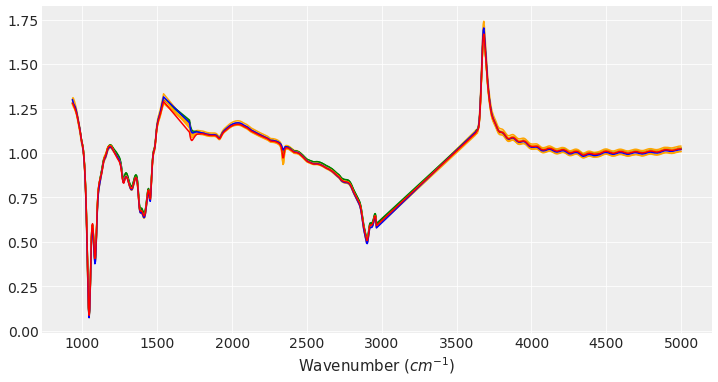

In [5]:
# name of column containing the labels
label_col = 'label'

# number of non-data columns at right of dataframe
non_data_cols = -2

# list of class labels
class_labels = utl.get_class_labels(data, label_col)

# plot dataframe
utl.plot_data(data, non_data_cols, label_col, 8)

In [6]:
#data.describe()

In [7]:
# number of samples from each class
data[label_col].value_counts()

CHI    15
AUS    12
SOU    11
ARG     6
Name: label, dtype: int64

In [8]:
# store data values for class A and B
df_a = data.query("label == @class_labels[0]")
df_b = data.query("label == @class_labels[1]")
df_c = data.query("label == @class_labels[2]")
df_d = data.query("label == @class_labels[3]")

x_n = data.columns[:non_data_cols]

x_sa = df_a[x_n].values
x_sb = df_b[x_n].values
x_sc = df_c[x_n].values
x_sd = df_d[x_n].values

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a..d} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [9]:
with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(len(class_labels),len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_sa[:len(x_sa)])
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_sb[:len(x_sb)])
    class_c = pm.Normal('class_c', mu=mu[2], sd=sigma, observed=x_sc[:len(x_sc)])
    class_d = pm.Normal('class_d', mu=mu[3], sd=sigma, observed=x_sd[:len(x_sd)])
    
    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:16<00:00, 65.50draws/s] 


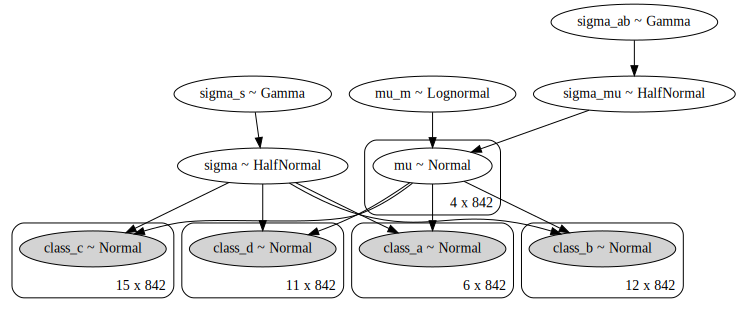

In [10]:
pm.model_to_graphviz(model_gm)

In [11]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",1.296,0.005,1.287,1.306,0.000,0.000,4115.0,4114.0,4112.0,2408.0,1.0
"mu[0,1]",1.292,0.005,1.282,1.301,0.000,0.000,3219.0,3219.0,3216.0,2900.0,1.0
"mu[0,2]",1.282,0.005,1.273,1.291,0.000,0.000,4530.0,4528.0,4528.0,2683.0,1.0
"mu[0,3]",1.274,0.005,1.265,1.283,0.000,0.000,3335.0,3335.0,3327.0,2665.0,1.0
"mu[0,4]",1.266,0.005,1.257,1.275,0.000,0.000,4718.0,4718.0,4704.0,2389.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,1.000,0.003,0.994,1.005,0.000,0.000,4271.0,4268.0,4309.0,2557.0,1.0
sigma_ab,0.592,0.614,0.067,1.694,0.012,0.009,2531.0,2531.0,3406.0,2546.0,1.0
sigma_mu,0.177,0.002,0.173,0.181,0.000,0.000,5060.0,5057.0,5058.0,2829.0,1.0
sigma_s,0.252,0.425,0.004,0.931,0.007,0.005,3240.0,3240.0,4137.0,3075.0,1.0


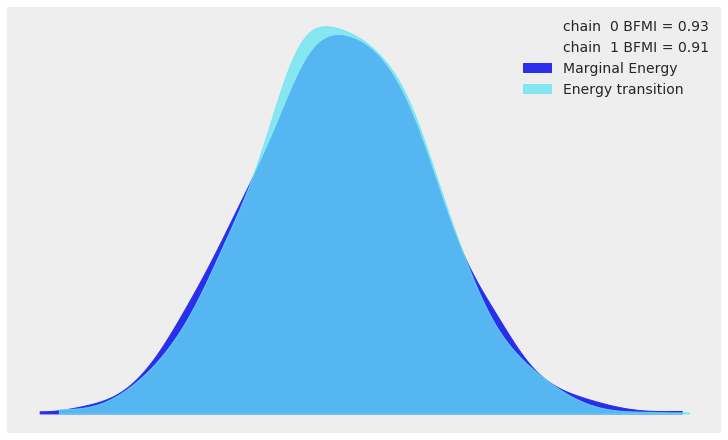

In [12]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [13]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:02<00:00, 120.44it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


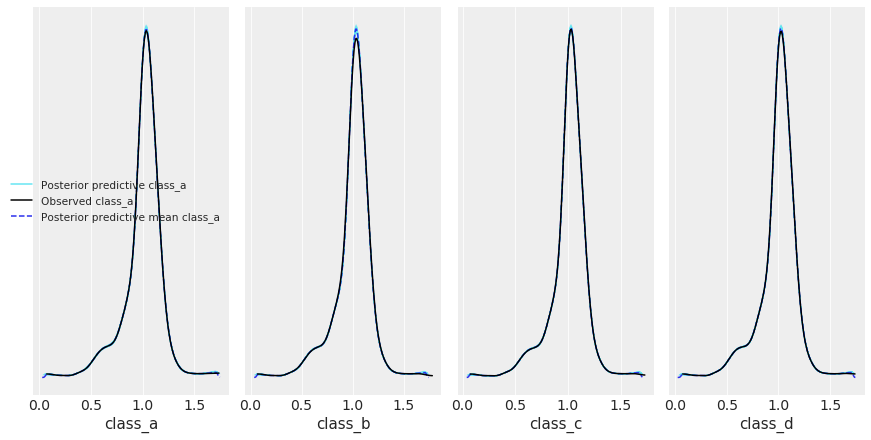

In [14]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [15]:
print(az.r2_score(x_sa[:len(x_sa)], ppc['class_a']))

r2        0.994564
r2_std    0.000479
dtype: float64


In [16]:
print(az.r2_score(x_sb[:len(x_sb)], ppc['class_b']))

r2        0.994914
r2_std    0.000452
dtype: float64


In [17]:
print(az.r2_score(x_sc[:len(x_sc)], ppc['class_c']))

r2        0.994663
r2_std    0.000475
dtype: float64


In [18]:
print(az.r2_score(x_sd[:len(x_sd)], ppc['class_d']))

r2        0.994889
r2_std    0.000455
dtype: float64


In [19]:
print(az.bfmi(trace_gm))

[0.92883475 0.90814151]


# Posterior samples vs. mean data

In [20]:
# class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']
cl_c = ppc['class_c']
cl_d = ppc['class_d']

ppc_class_lst = [cl_a, cl_b, cl_c, cl_d]

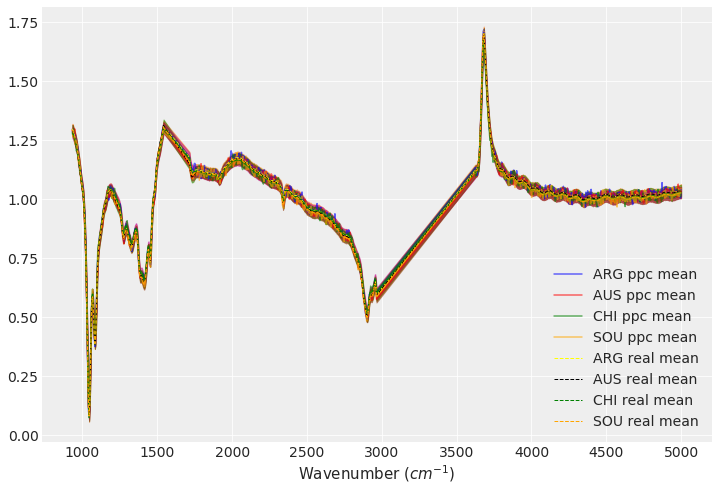

In [21]:
utl.plot_mean_vs_ppc(data, ppc_class_lst, non_data_cols, label_col)

# Real spectrum vs. posterior samples

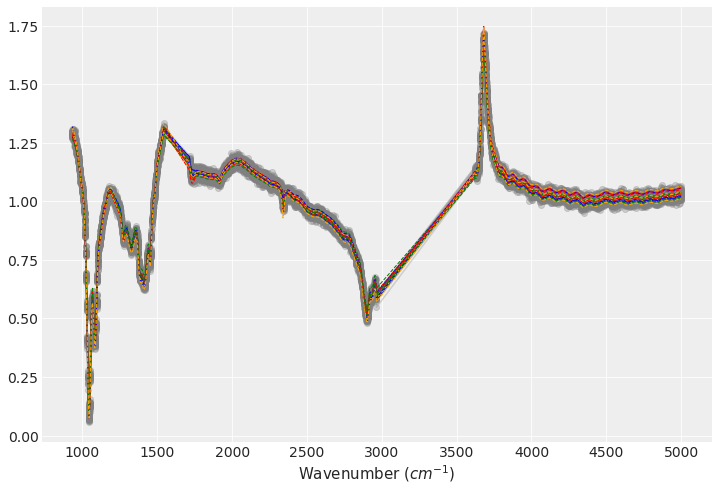

In [22]:
utl.plot_real_vs_ppc(data, ppc_class_lst, non_data_cols, label_col, 5)

# Save posterior samples to .csv file

In [23]:
x_val = utl.get_data_x_value_header(data, non_data_cols)
samples_per_class = 50
filename = './ppc_samples_wines.csv' 

utl.save_traces(filename, samples_per_class, x_val, class_labels, ppc_class_lst)